In [37]:
import torch
import numpy as np
import pandas as pd
from time import time
import tracemalloc
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

from memory_profiler import memory_usage

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.metrics as metrics
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

In [38]:
def analytical_solution(x, t, alpha):
    return np.exp(-alpha**2 * np.pi**2 * t) * np.sin(np.pi * x)

### FEM

In [39]:
def solve_heat_equation_fem(alpha, L, T, n_elements, initial_condition, boundary_conditions):
    dx = L / (n_elements - 1)
    dt = dx**2 / (4*alpha**2)
    Nt = int(T / dt)
    nodes = np.linspace(0, L, n_elements+1)
    
    M = np.zeros((n_elements + 1, n_elements + 1))
    K = np.zeros((n_elements + 1, n_elements + 1))

    for i in range(n_elements):
        h = nodes[i+1] - nodes[i]
        M_local = (h / 6) * np.array([[2, 1], [1, 2]])
        K_local = (1 / h) * np.array([[1, -1], [-1, 1]])
        
        M[i:i+2, i:i+2] += M_local
        K[i:i+2, i:i+2] += K_local
    
    u = np.zeros(n_elements+1)
    u_new = np.zeros_like(u)
    
    u[:] = initial_condition(nodes)
    
    A = sp.csr_matrix(M + (alpha * dt / 2) * K)
    B = sp.csr_matrix(M - (alpha * dt / 2) * K)
    
    def apply_boundary_conditions(u):
        u[0] = boundary_conditions[0](0)
        u[-1] = boundary_conditions[1](0)
        return u

    for step in range(Nt):
        u = apply_boundary_conditions(u)
        b = B @ u
        u_new = spla.spsolve(A, b)
        u[:] = u_new
    
    return nodes, u_new

### FVM

In [40]:
def solve_heat_equation_fvm(alpha, L, T, Nx, initial_condition, boundary_conditions):
    dx = L / (Nx - 1)
    dt = dx**2 / (2*alpha**2)
    Nt = int(T / dt)
    x = np.linspace(0, L, Nx)
    U = np.zeros((Nt, Nx))
    print(f"FVM domian size: ({Nx}, {Nt})")
    U[0, :] = initial_condition(x)
    
    for n in range(0, Nt - 1):
        for i in range(1, Nx - 1):
            flux_left = (U[n, i-1] - U[n, i]) / dx
            flux_right = (U[n, i+1] - U[n, i]) / dx
            U[n + 1, i] = U[n, i] + alpha**2 * dt / dx * (flux_left + flux_right)
        
        U[n + 1, 0] = boundary_conditions[0](n * dt)
        U[n + 1, -1] = boundary_conditions[1](n * dt)
    
    return x, U[-1]

### FDM

In [41]:
def solve_heat_equation_fdm(alpha, L, T, Nx, initial_condition, boundary_conditions):
    dx = L / (Nx - 1)
    dt = dx**2 / (2*alpha**2)
    Nt = int(T / dt)
    x = np.linspace(0, L, Nx)
    U = np.zeros((Nt, Nx))
    print(f"FDM domian size: ({Nx}, {Nt})")
    U[0, :] = initial_condition(x)
    
    for n in range(0, Nt - 1):
        U[n + 1, 1:-1] = U[n, 1:-1] + alpha**2 * dt / dx**2 * (U[n, :-2] - 2 * U[n, 1:-1] + U[n, 2:])
        U[n + 1, 0] = boundary_conditions[0](n * dt)
        U[n + 1, -1] = boundary_conditions[1](n * dt)
    
    return x, U[-1]

### PINN

In [42]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=2,
					output=1,
					hidden_layers=[int(32) for _ in range(1)],
					epochs=1000,
					batch_size=100,
					lr=0.001,
					activation='sin',
					training_mode='train',
					regularization='Elastic',
					lambda_reg=0.01,
					optimizer='Adam',
					scheduler=None,
					early_stopping=True,
					use_rar=False,
					use_weights_adjuster=False,
					display_interval=1000,
					model_save_path='models',
					output_path='out',
					save_loss=True,
					initial_weights_path=None, # 'models/model_weights.pth'
					siren_params=siren_params)

### Comparison

In [103]:
def analytical_solution(x, t, alpha, L):
    return np.exp(-alpha**2 * (np.pi / L)**2 * t) * np.sin(np.pi * x / L)

# def analytical_solution(x, t, alpha, L):
#     return np.exp(-alpha * (np.pi / L)**2 * t) * np.sin(np.pi * x / L)

# Compute error
def compute_error(numerical_solution, analytical_solution, x_numerical, x_analytical):
    interp_analytical = np.interp(x_numerical, x_analytical, analytical_solution)
    return np.sqrt(np.mean((numerical_solution - interp_analytical)**2))

In [45]:
def run_simulation(filename, n_elements_range, alpha, L, T, 
				   initial_condition_func, initial_condition_func_pinn, 
				   boundary_conditions_func, boundary_conditions_func_pinn):
	results = []
    
	for n_elements in n_elements_range:
		# FEM
		# start_time = time()
		# tracemalloc.start()
		# x_fem, U_fem = solve_heat_equation_fem(alpha, L, T, n_elements-1, initial_condition_func, boundary_conditions_func)
		# memory_usage_fem, _ = tracemalloc.get_traced_memory()
		# tracemalloc.stop()
		# time_fem = time() - start_time

		# FVM
		start_time = time()
		tracemalloc.start()
		x_fvm, U_fvm = solve_heat_equation_fvm(alpha, L, T, n_elements, initial_condition_func, boundary_conditions_func)
		memory_usage_fvm, _ = tracemalloc.get_traced_memory()
		tracemalloc.stop()
		time_fvm = time() - start_time

		# FDM
		start_time = time()
		tracemalloc.start()
		x_fdm, U_fdm = solve_heat_equation_fdm(alpha, L, T, n_elements, initial_condition_func, boundary_conditions_func)
		memory_usage_fdm, _ = tracemalloc.get_traced_memory()
		tracemalloc.stop()
		time_fdm = time() - start_time

		# PINN
		geom = geometry.Interval(0.0, L)
		period = timedomain.TimeDomain(0.0, T)

		initial_conditions = conditions.InitialConditions()
		initial_conditions.set_initial_conditions(geom=geom, time=period, 
												initial_func=initial_condition_func_pinn, 
												num_points=int(n_elements/3), random=False, device="cuda:0")

		boundary_conditions = conditions.BoundaryConditions()
		boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
													boundary_func=boundary_conditions_func_pinn, 
													num_points=int(n_elements/3), random=False, device="cuda:0")

		pde_heat = pde.PDE('heat', alpha=alpha)

		equation = conditions.Equation()
		equation.set_equation(pde=pde_heat, geom=geom, time=period, 
							num_points=int(n_elements/3), random=False, device="cuda:0")

		test = conditions.Test()
		test.set_test(geom=geom, time=period, num_points=n_elements, random=False, device="cuda:0")

		problem = conditions.Problem(initial_conditions, boundary_conditions, 
									equation, test, geom, period, alpha=alpha)

		model = pinn.PINN(problem, net_params, device='cuda:0')

		start_time = time()
		tracemalloc.start()
		model.train()
		memory_usage_pinn, _ = tracemalloc.get_traced_memory()
		tracemalloc.stop()
		time_pinn = time() - start_time

		x, t = problem.test.get_test()
		u_pinn = model.predict(x, t).cpu().detach().numpy()
		x = x.cpu().detach().numpy()

		# Analytical solution
		x_analytical = np.linspace(0, L, n_elements)
		U_analytical = analytical_solution(x_analytical, T, alpha, L)
		
		# error_fem = compute_error(U_fem, U_analytical, x_fem, x_analytical)
		error_fvm = compute_error(U_fvm, U_analytical, x_fvm, x_analytical)
		error_fdm = compute_error(U_fdm, U_analytical, x_fdm, x_analytical)
		error_pinn = compute_error(u_pinn, U_analytical, x, x_analytical)

		# results.append({
		# 	'n_elements': n_elements,
		# 	'method': 'FEM',
		# 	'error': error_fem,
		# 	'time': time_fem,
		# 	'memory': memory_usage_fem / 1024
		# })
		results.append({
			'n_elements': n_elements,
			'method': 'FVM',
			'error': error_fvm,
			'time': time_fvm,
			'memory': memory_usage_fvm / 1024
		})
		results.append({
			'n_elements': n_elements,
			'method': 'FDM',
			'error': error_fdm,
			'time': time_fdm,
			'memory': memory_usage_fdm / 1024
		})
		results.append({
			'n_elements': n_elements,
			'method': 'PINN',
			'error': error_pinn,
			'time': time_pinn,
			'memory': memory_usage_pinn / 1024
		})

		# Save results to CSV
		df = pd.DataFrame(results)
		df.to_csv(filename, index=False)

In [44]:
L = 1.0
T = 0.5
alpha = 0.1
initial_condition_func = lambda x: np.sin(np.pi * x / L)
initial_condition_func_pinn = lambda x: torch.sin(torch.pi * x / L).reshape(-1, 1)
boundary_conditions_func = (lambda t: 0, lambda t: 0)
boundary_conditions_func_pinn = lambda x, t: torch.zeros_like(x)

csv_filename = 'heat_equation_results.csv'
# n_elements = [100, 500, 1000, 2500, 5000, 10000]
n_elements = [5000]
# n_elements = [500]
run_simulation(csv_filename, n_elements, alpha, L, T, 
               initial_condition_func, initial_condition_func_pinn, 
               boundary_conditions_func, boundary_conditions_func_pinn)

FVM domian size: (5000, 249900)


KeyboardInterrupt: 

n_elements,method,error,time,memory
100,FVM,0.00033515154952334507,0.11893129348754883,83.650390625
100,FDM,0.0003351515495235219,0.0024042129516601562,77.8232421875
100,PINN,0.017817858617905618,7.378261089324951,16.484375

500,FVM,1.3239893442731239e-05,14.282306432723999,9737.0322265625
500,FDM,1.3239893443393487e-05,0.05576586723327637,9736.11328125
500,PINN,1.705419890640769e-04,7.2441418170928955,16.3037109375

1000,FVM,3.304964031271899e-06,124.73645281791687,77983.2509765625
1000,FDM,3.304964031592939e-06,6.24192428588867188,77982.6630859375
1000,PINN,8.585595060139894e-05,7.293795585632324,14.08984375

2500,FVM,5.283163979250796e-07,1913.725157737732,1219752.9384765625
2500,FDM,5.283163981348409e-07,12.5591800212860107,1219752.8359375
2500,PINN,3.0858704121783376e-05,8.709657430648804,13.0380859375

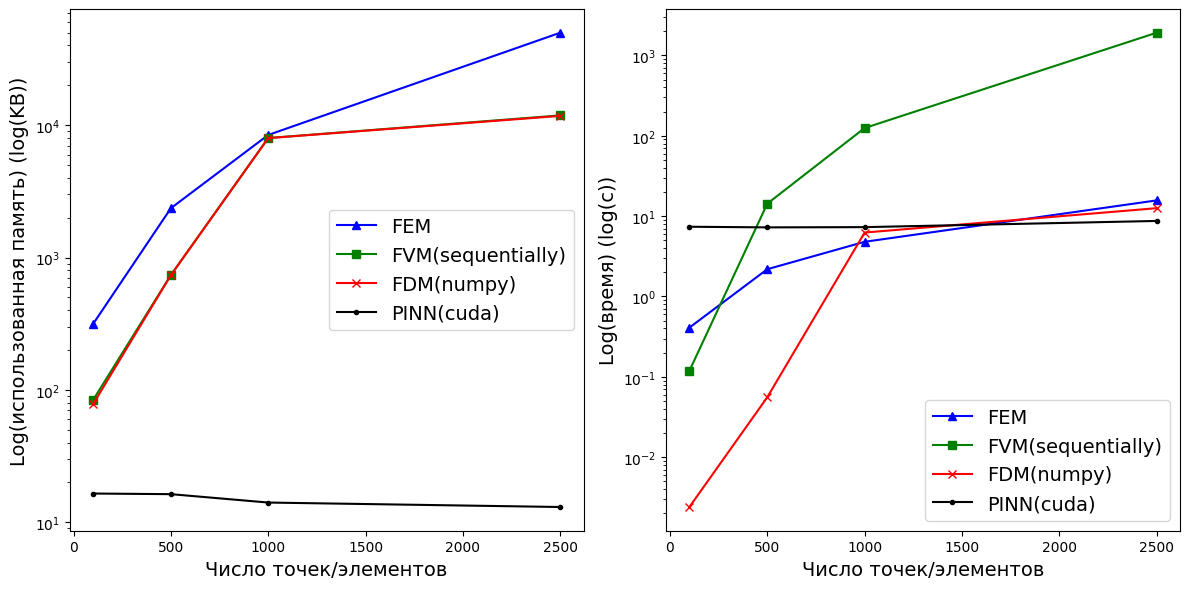

In [49]:
csv_filename = 'heat_equation_results.csv'
df = pd.read_csv(csv_filename)

# Построение графиков
methods = df['method'].unique()
# methods = ['FDM', 'PINN']
method_name  = {'FEM': 'FEM', 
                'FVM': 'FVM(sequentially)', 
                'FDM': 'FDM(numpy)', 
                'PINN': 'PINN(cuda)'}

plt.figure(figsize=(12, 6))
font_size= 14
colors = {'FEM': 'blue',
          'FVM': 'green',
          'FDM': 'red',
          'PINN': 'black'}
markers  = {'FEM': '^',
            'FVM': 's',
            'FDM': 'x',
            'PINN': '.'}

plt.subplot(1, 2, 1)
for method in methods:
    method_data = df[df['method'] == method]
    plt.plot(method_data['n_elements'], method_data['memory'], 
             label=method_name[method], c=colors[method], marker=markers[method])
plt.xlabel('Число точек/элементов', fontsize=font_size)
plt.ylabel('Log(использованная память) (log(KB))', fontsize=font_size)
plt.yscale('log')
plt.legend(fontsize=font_size)

plt.subplot(1, 2, 2)
for method in methods:
    method_data = df[df['method'] == method]
    plt.plot(method_data['n_elements'], method_data['time'], 
             label=method_name[method], c=colors[method], marker=markers[method])
plt.xlabel('Число точек/элементов', fontsize=font_size)
plt.ylabel('Log(время) (log(с))', fontsize=font_size)
plt.yscale('log')
plt.legend(fontsize=font_size)

plt.tight_layout()
plt.show()